In [1]:
import ROOT
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import glob
%jsroot
from tqdm import tqdm
from array import array
import itertools
from collections import defaultdict
from collections import Counter
import pandas as pd
import random
import pickle

import scipy.stats as stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.spatial import KDTree

import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import DynamicEdgeConv, TransformerConv, Set2Set, GlobalAttention
from torch_geometric.data import Batch
from torch.nn import Sequential, Linear, ReLU
from torch_cluster import radius_graph
from torch_cluster import knn_graph
import torch.nn.functional as F
from math import acos, degrees

from torch import nn
from torch_geometric.nn import (
    DynamicEdgeConv,
    GATConv,
    global_mean_pool,
    knn_graph
)
from torch_geometric.utils import to_dense_batch
import matplotlib.patches as mpatches
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss

Welcome to JupyROOT 6.30/04


In [2]:
layout_file = ROOT.TFile("/mnt/e/testML/pie/run00000-00.root")
geohelper = layout_file.Get("PIMCGeoHelper")
layout = geohelper.GetLayout("CALORIMETER", "TP2")

In [3]:
pdg_to_idx = {pdg: i for i, pdg in enumerate([211,-13,-11,11,98105])}
# Bitmask constants (1 bit per particle type)
PION      = 0b00001  # 1
MUON      = 0b00010  # 2
POSITRON  = 0b00100  # 4
ELECTRON  = 0b01000  # 8
OTHER     = 0b10000  # 16

def pdg_to_mask(pdg_id):
    if pdg_id == 211: return PION
    elif pdg_id == -13: return MUON
    elif pdg_id == -11:       return POSITRON
    elif pdg_id == 11:        return ELECTRON
    else:                     return OTHER

MASK_TO_PDG = {
    0b00001: 211,    # pion
    0b00010: -13,     # muon
    0b00100: -11,    # positron
    0b01000: 11,     # electron
    0b10000: 98105    # other
    }

def decode_mask(mask):
    """
    Given a bitmask, return a list of PDG IDs it represents.
    """
    return [pdg for bit, pdg in MASK_TO_PDG.items() if mask & bit]

In [4]:
def smear(energy,energy_resolution):
    stdv = energy * energy_resolution
    smeared_energy = energy + np.random.normal(0,stdv)
    return smeared_energy

In [5]:
MERGE_WINDOW = 2
GROUP_WINDOW = 1
def group_hits_in_time(allHits, time_window_ns=GROUP_WINDOW):
    """
    Groups hits into clusters where each hit is within `time_window_ns`
    of the first hit in the group.

    Parameters:
        allHits: dict mapping pixelID -> list of np.array hits
                 where each hit is [x/y, z, stripType, energy, time, pdg, eventNum]
        time_window_ns: max allowed time separation within a group

    Returns:
        List of groups, where each group is a list of np.ndarray hits (no pixelID)
    """
    # Flatten all hits into a list of hit_array
    hit_list = []
    for hits in allHits.values():
        hit_list.extend(hits)

    # Sort hits by time (index 4)
    hit_list.sort(key=lambda hit: hit[4])

    #print(len(allHits), len(hit_list), "hits in total")

    groups = []
    current_group = []
    group_time = None

    for hit in hit_list:
        time = hit[4]
        if not current_group:
            current_group.append(hit)
            group_time = time
        elif abs(time - group_time) <= time_window_ns:
            current_group.append(hit)
            group_time = time
        else:
            total_energy = sum(h[3] for h in current_group)
            group_with_energy = [np.append(h, total_energy/1) for h in current_group]
            random.shuffle(group_with_energy)
            groups.append(np.array(group_with_energy))
            #random.shuffle(current_group)
            #groups.append(np.array(current_group))
            current_group = [hit]
            group_time = time

    if current_group:
        total_energy = sum(h[3] for h in current_group)
        group_with_energy = [np.append(h, total_energy/1) for h in current_group]
        random.shuffle(group_with_energy)
        groups.append(np.array(group_with_energy))
        #random.shuffle(current_group)
        #groups.append(np.array(current_group))
    #print([print(group) for group in groups])

    return groups

In [6]:
def groupID(groupList):
    """
    This function takes in a list of groups of hits, and returns the unique PDG IDs
    associated with each group, based on bitmask encoding. A PDG ID is kept only if it
    appears in at least two hits in the group; if none do, all are kept.
    """
    unique_pdg_per_group = []

    for group in groupList:
        all_decoded_pdgs = []
        for hit in group:
            mask = int(hit[5])
            all_decoded_pdgs.extend(decode_mask(mask))

        pdg_counts = Counter(all_decoded_pdgs)
        unique_pdgs = [pdg for pdg, count in pdg_counts.items() if count >= 2]

        if not unique_pdgs:
            unique_pdgs = list(pdg_counts.keys())

        unique_pdg_per_group.append(unique_pdgs)

    return unique_pdg_per_group

In [7]:
def groupMerger(groupList, prob=1.0):
    if len(groupList) != 3:
        return groupList

    if random.random() < prob:
        start_idx = random.choice([0, 1])
        idx1, idx2 = start_idx, start_idx + 1

        group1 = groupList[idx1]
        group2 = groupList[idx2]

        merged_dict = {}

        # Collect all hits from both groups
        for hit in np.concatenate((group1, group2)):
            # Define unique position key
            key = (hit[0], hit[1], int(hit[2]))  # (coord, z, stripType)

            if key not in merged_dict:
                merged_dict[key] = hit.copy()
            else:
                existing_hit = merged_dict[key]
                existing_hit[3] += hit[3]  # merge energy
                existing_hit[4] = min(existing_hit[4], hit[4])  # keep earliest time
                existing_hit[5] = int(existing_hit[5]) | int(hit[5])  # merge pdg bitmasks

        # Final merged array
        merged = np.array(list(merged_dict.values()))
        np.random.shuffle(merged)

        # Replace original groups
        for idx in sorted([idx1, idx2], reverse=True):
            groupList.pop(idx)
        groupList.insert(idx1, merged)

    return groupList

In [8]:
kPidif  = 0x0000000010
def process_time_groups(sample_chains, max_events=10000, geohelper=geohelper, enhanceMerge=False, pionstop=True, positronAngle=True):
    """
    Processes sample chains to extract time-grouped hits and their labels per event.

    Parameters:
        sample_chains (dict): Mapping of run -> TChain or iterable of entries.
        geohelper: Geometry helper with GetX/Y/Z and GetPsi methods.
        smear (func): Smearing function that takes (energy, resolution).
        group_hits_in_time (func): Function to time-group hits.
        groupID (func): Function to generate group labels from time groups.
        max_events_per_chain (int): Max number of events to process per run.

    Returns:
        eventTimeGroups (dict): Mapping event index -> grouped hit arrays.
        timeGroupLabels (dict): Mapping event index -> group label list.
    """
    MERGE_WINDOW = 2
    eventTimeGroups = np.empty(max_events, dtype=object)
    timeGroupLabels = np.empty(max_events, dtype=object)
    if pionstop:
        pionStops = np.empty(max_events, dtype=object)
    if positronAngle:
        positronAngles = np.empty(max_events, dtype=object)

    eventNumber = 0

    events_per_chain = max_events // len(sample_chains)

    for run, chain in tqdm(sample_chains.items()):
        events_taken = 0

        triggered = 0
        
        for entry in chain:

            if events_taken >= events_per_chain or eventNumber >= max_events:
                break

            eventType = int(entry.info.GetType())
            if eventType & kPidif:
                # Skip events that are of type kPidif
                continue
                
            allHits = {}

            triggered = 0
            for upstream in entry.upstream:
                if upstream.GetUpstreamID() == 99999:
                    energyDTAR = upstream.GetTotalEnergyDeposit()
                    if energyDTAR > 1:
                        triggered = 1
                    
            if not triggered:
                eventTimeGroups[eventNumber] = []
                timeGroupLabels[eventNumber] = []
                if pionstop:
                    pionStops[eventNumber] = []
                if positronAngle:
                    positronAngles[eventNumber] = []
                continue

            pion_in_atar = 0
            pion_stop_position = (-100, -100, -100)
            pion_time = 0

            thetaInit, phiInit = -1000, -1000
            positron_in_atar = 0

            evil_event= 0

            merged_pdgs_counter = {}
            merged_pixels = []

            for decay in entry.decay:
                nD = decay.GetNDaughters()
                if run == 'michel':
                    if nD != 3:
                        breaker = 1
                        continue
                    if (nD == 3):
                        #decayTime = decay.GetTime()
                        #truthMom = mom.R()
                        #truthEnergy = np.sqrt((ELECTRON_MASS ** 2) + truthMom**2) + ELECTRON_MASS
                        mom = decay.GetDaughterMomAt(2)
                        #pdg = decay.GetDaughterPDGIDAt(2)
                        thetaInit = mom.Theta()
                        phiInit = mom.Phi()
                        continue
                elif run == 'pie':
                    if nD != 2:
                        breaker = 1
                        continue
                    if (nD == 2):
                        #decayTime = decay.GetTime()
                        #truthMom = mom.R()
                        #truthEnergy = np.sqrt((ELECTRON_MASS ** 2) + truthMom**2) + ELECTRON_MASS
                        mom = decay.GetDaughterMomAt(1)
                        #pdg = decay.GetDaughterPDGIDAt(1)
                        thetaInit = mom.Theta()
                        phiInit = mom.Phi()
                        continue
            
            for atarHit in entry.atar:
                pdg = atarHit.GetPDGID()
                if pdg not in [211, -11, -13,11]:
                    continue
            
                if pdg not in [211,-11,-13,11]:
                    print('evil')
                    evil_event = 1

                pdg_binary = pdg_to_mask(pdg)

                hitTime = atarHit.GetTime() + np.random.normal(0, 0.2)
                pixelID = atarHit.GetPixelID()
                edep = atarHit.GetEdep()
                energySmeared = smear(edep, 0.15)
                stripType = abs(abs(geohelper.GetPsi(pixelID)) - 0.0) > 0.01

                coord = geohelper.GetY(pixelID) if stripType else geohelper.GetX(pixelID)
                z = geohelper.GetZ(pixelID)
                hit = np.array([coord, z, stripType, energySmeared, hitTime, pdg_binary, eventNumber])

                if pdg == 211:
                    pion_in_atar = 1
                    if pionstop:
                        if atarHit.GetTime() > pion_time:
                            pion_time = atarHit.GetTime()
                            pion_stop_position = ((atarHit.GetX0()+atarHit.GetX1())/2, (atarHit.GetY0()+atarHit.GetY1())/2, (atarHit.GetZ0()+atarHit.GetZ1())/2)

                if pdg == -11:
                    positron_in_atar = 1


                if pixelID in allHits:
                    merged = False
                    for existing_hit in allHits[pixelID]:
                        if abs(existing_hit[4] - hitTime) < MERGE_WINDOW:
                            existing_hit[3] += energySmeared
                            existing_hit[5] = int(existing_hit[5]) | int(pdg_binary)
                            if pixelID not in merged_pixels:
                                merged_pixels.append(pixelID)
                            merged = True
                            break
                    if not merged:
                        allHits[pixelID].append(hit)
                else:
                    allHits[pixelID] = [hit]

            if len(allHits) < 10:
                evil_event = 1

            if ((not pion_in_atar) or evil_event or (not positron_in_atar)):
                eventTimeGroups[eventNumber] = []
                timeGroupLabels[eventNumber] = []
                if pionstop:
                    pionStops[eventNumber] = []
                if positronAngle:
                    positronAngles[eventNumber] = []
                continue
            
            #if len(allHits) > 200:
            #    print(len(allHits), "hits in event", eventNumber, "run", run)

            # Time-grouping
            groups = group_hits_in_time(allHits)

            #for group in groups:
            #    if len(group) > 200:
            #        print(len(group), "hits in group", eventNumber, "run", run)
                
            if enhanceMerge:
                groups = groupMerger(groups,1.0)

            groupLabels = groupID(groups)

            eventTimeGroups[eventNumber] = groups
            timeGroupLabels[eventNumber] = groupLabels
            if pionstop:
                pionStops[eventNumber] = pion_stop_position
            if positronAngle:
                positronAngles[eventNumber] = [thetaInit, phiInit]

            events_taken += 1
            eventNumber += 1

    # Find indices of empty events
    empty_indices = [i for i, groups in enumerate(eventTimeGroups) if len(groups) == 0]
    
    # Convert to NumPy arrays with object dtype to allow deletion by index
    eventTimeGroupsCleaned = np.array(eventTimeGroups, dtype=object)
    timeGroupLabelsCleaned = np.array(timeGroupLabels, dtype=object)
    pionStopsCleaned = np.array(pionStops, dtype=object) if pionstop else None
    positronAnglesCleaned = np.array(positronAngles, dtype=object) if positronAngle else None
    eventIndexCleaned = np.array(list(range(max_events)))
    
    # Remove empty events
    eventTimeGroupsCleaned = np.delete(eventTimeGroupsCleaned, empty_indices)
    timeGroupLabelsCleaned = np.delete(timeGroupLabelsCleaned, empty_indices)
    eventIndexCleaned = np.delete(eventIndexCleaned, empty_indices)
    pionStopsCleaned = np.delete(pionStopsCleaned, empty_indices) if pionstop else None
    positronAnglesCleaned = np.delete(positronAnglesCleaned, empty_indices) if positronAngle else None

    flat_arr = []
    group_index_dict = {}
    
    for event_idx, event in enumerate(timeGroupLabelsCleaned):
        for group_idx, group in enumerate(event):
            flat_arr.append(group)
            flat_index = len(flat_arr) - 1
            group_index_dict[flat_index] = (event_idx, group_idx)

    if pionstop and not positronAngle:
        return eventTimeGroupsCleaned, timeGroupLabelsCleaned, eventIndexCleaned, group_index_dict, pionStopsCleaned
    elif positronAngle:
        return eventTimeGroupsCleaned, timeGroupLabelsCleaned, eventIndexCleaned, group_index_dict, pionStopsCleaned, positronAnglesCleaned
    else:
        return eventTimeGroupsCleaned, timeGroupLabelsCleaned, eventIndexCleaned, group_index_dict

In [9]:
class SplitterDatasetBhabha(Dataset):
    def __init__(self, event_pos_group, positron_angle, pion_stops):
        self.groups = event_pos_group
        self.positron_angle = positron_angle
        self.pion_stops = pion_stops

    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        group = np.array(self.groups[idx])
        coords = group[:, 0]
        zs = group[:, 1]
        strip_types = group[:, 2].astype(int)
        energy = group[:, 3]
        time = group[:, 4]
        pdgs = group[:, 5].astype(int)
        event_number = group[:, 6]
        group_E = group[:, 7]

        # One-hot encode strip type
        view0 = (strip_types == 0).astype(float)
        view1 = (strip_types == 1).astype(float)

        # Input features
        #x = torch.tensor(np.stack([coords, zs, energy, view0, view1, group_E], axis=1), dtype=torch.float)
        x = torch.tensor(np.stack([coords, zs, view0, view1, energy], axis=1), dtype=torch.float)

        #Is the hit a positron or not?
        y = torch.tensor([0 if (pdg & POSITRON) else 1 for pdg in pdgs], dtype=torch.long)
        event_id = torch.tensor(event_number, dtype=torch.int)
        piStop1 = self.pion_stops[idx]
        piStop2 = torch.tensor(piStop1, dtype=torch.float).reshape(1, 3)

        angles = self.positron_angle[idx]
        vec3d = torch.tensor([np.sin(angles[0]) * np.cos(angles[1]),
                              np.sin(angles[0]) * np.sin(angles[1]),
                              np.cos(angles[0])], dtype=torch.float)

        return Data(x=x,  y=y, pionStop=piStop2, event_id=event_id, positron_angle=vec3d)

In [ ]:
class FullTransformerBlock(nn.Module):
    def __init__(self, hidden_channels, heads, dropout):
        super().__init__()
        self.attn = TransformerConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels // heads,
            heads=heads,
            dropout=dropout,
            concat=True,
            edge_dim=2
        )
        self.norm1 = nn.LayerNorm(hidden_channels)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 4),
            nn.ReLU(),
            nn.Linear(hidden_channels * 4, hidden_channels)
        )
        self.norm2 = nn.LayerNorm(hidden_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr=None):
        y = self.attn(x, edge_index, edge_attr)
        x = self.norm1(x + self.dropout(y))
        y2 = self.ffn(x)
        x = self.norm2(x + self.dropout(y2))
        return x

class BhabhaSplitterGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, heads=4, dropout=0.2):
        super().__init__()
        # Initial embedding of node features
        self.lin_embed = nn.Linear(in_channels, hidden_channels)
        # Two full transformer blocks
        self.block1 = FullTransformerBlock(hidden_channels, heads, dropout)
        self.block2 = FullTransformerBlock(hidden_channels, heads, dropout)
        # Final classifier: [is_pion, is_muon, is_both]
        self.output = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels), 
            nn.ReLU(),
            nn.Linear(hidden_channels, 2)
        )

    def forward(self, data):
        x = self.lin_embed(data.x)  # [N, hidden_channels]
        batch = data.batch

        edge_indices = []
        for event_id in torch.unique(batch):
            mask = batch == event_id
            idx = mask.nonzero(as_tuple=True)[0]
            num = idx.size(0)
            row = torch.arange(num, device=idx.device).repeat_interleave(num)
            col = torch.arange(num, device=idx.device).repeat(num)
            mask_nc = row != col
            ei = torch.stack([idx[row[mask_nc]], idx[col[mask_nc]]], dim=0)
            edge_indices.append(ei)

        edge_index = torch.cat(edge_indices, dim=1)  # shape: [2, E]

        x = self.block1(x, edge_index)
        x = self.block2(x, edge_index)

        out = self.output(x)
        return out

class SecondaryElectronTagger(nn.Module):
    def __init__(self, in_channels=4, hidden_channels=64, heads=4, dropout=0.2, k=12):
        super().__init__()
        self.lin_embed = nn.Linear(in_channels, hidden_channels)
        self.block1    = FullTransformerBlock(hidden_channels, heads, dropout)
        self.block2    = FullTransformerBlock(hidden_channels, heads, dropout)
        self.out       = nn.Sequential(
            nn.Linear(hidden_channels + 3, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 2)
        )
        self.k = k

    def forward(self, data):
        x = self.lin_embed(data.x)             # [N, hidden]
        pos2d = data.x[:, :2]                  # [N,2] = (coord, z)
        view0, view1 = data.x[:,2], data.x[:,3]  # one‑hot flags

        edge_indices = []
        edge_attrs   = []

        # --- build kNN within x-z view only ---
        #'''
        idx0 = (view0 == 1).nonzero(as_tuple=True)[0]
        if idx0.numel() > self.k:
            pos0   = pos2d[idx0]
            batch0 = data.batch[idx0]
            ei0    = knn_graph(pos0, k=self.k, batch=batch0)
            ei0    = idx0[ei0]
            edge_indices.append(ei0)

        idx1 = (view1 == 1).nonzero(as_tuple=True)[0]
        if idx1.numel() > self.k:
            pos1   = pos2d[idx1]
            batch1 = data.batch[idx1]
            ei1    = knn_graph(pos1, k=self.k, batch=batch1)
            ei1    = idx1[ei1]
            edge_indices.append(ei1)
        #'''
        '''
        idx0 = (view0 == 1).nonzero(as_tuple=True)[0]
        if idx0.numel() > 1:
            idx_grid = torch.cartesian_prod(idx0, idx0)
            mask = idx_grid[:,0] != idx_grid[:,1]
            ei0 = idx_grid[mask].T  # shape [2, E]
            edge_indices.append(ei0)

        # View 1: y-z
        idx1 = (view1 == 1).nonzero(as_tuple=True)[0]
        if idx1.numel() > 1:
            idx_grid = torch.cartesian_prod(idx1, idx1)
            mask = idx_grid[:,0] != idx_grid[:,1]
            ei1 = idx_grid[mask].T
            edge_indices.append(ei1)
        '''

        # --- combine view‑specific edges ---
        edge_index = torch.cat(edge_indices, dim=1)  # [2, E_total]

        # --- compute edge_attr if you like distances ---
        row, col = edge_index
        delta = pos2d[col] - pos2d[row]
        dist = delta.norm(dim=1, keepdim=True)
        #edge_attr = torch.cat([delta, dist], dim=1)
        edge_attr = delta

        # --- message passing ---
        h = self.block1(x, edge_index, edge_attr)
        h = self.block2(h, edge_index, edge_attr)

        pion_stop = data.pionStop[data.batch] 
        h_combined = torch.cat([h, pion_stop], dim=1)


        return self.out(h_combined)

In [11]:
def train_bhabha_splitter(model, loader, optimizer, num_epochs=10):

    history = []

    device = next(model.parameters()).device
    model.to(device)

    class_weights = torch.tensor([1.0, 1.0], device=device)
    criterion = CrossEntropyLoss(weight=class_weights)

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_nodes = 0

        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()

            out = model(data)               # [num_nodes, ]
            target = data.y.long()          # [num_nodes], values in {0, 1}
            loss = criterion(out, target)

            loss.backward()
            optimizer.step()

            # Accuracy
            preds = out.argmax(dim=1)
            correct = (preds == target).sum().item()
            total_correct += correct
            total_nodes += target.size(0)
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        avg_acc = total_correct / total_nodes

        print(f"Epoch {epoch:02d}: Loss = {avg_loss:.4f}, Accuracy = {avg_acc:.4f}")

        history.append({
            "epoch": epoch,
            "loss": avg_loss,
            "accuracy": avg_acc,
        })


In [12]:
main_file_list = ['michel']
main_chains = {s : ROOT.TChain("sim") for s in main_file_list}
for name,c in main_chains.items():
    print(name)
    #[c.Add(filepath) for filepath in glob.glob("/mnt/e/testML/{}/*.root".format(name))]
    [c.Add(filepath) for filepath in glob.glob("/mnt/e/testML/testData/{}/*.root".format(name))]

main_chains['michel'].GetEntries()

michel


1000000

In [13]:
mainTimeGroups, mainTimeGroupLabels, mainEventIndex, main_group_index_dict, pStops, posAngles = process_time_groups(main_chains, max_events=500000, geohelper=geohelper)

100%|██████████| 1/1 [44:31<00:00, 2671.24s/it]


In [14]:
groups_bhabha = []
piStops_bhabha = []
posAngles_bhabha = []


for event,pS,pA in zip(mainTimeGroups,pStops,posAngles):
    for group in event:
        pdgs = group[:, 5].astype(int)  # extract PDGs as ints
        #masked = [0 if (pdg & POSITRON) else 1 for pdg in pdgs]
        #if (((4 in pdgs) and (8 in pdgs)) or (12 in pdgs)):
        if (((4 in pdgs) and (8 in pdgs))):
            #print(pdgs)
            #print(masked)
            groups_bhabha.append(group)
            piStops_bhabha.append(pS)
            posAngles_bhabha.append(pA)


print(len(groups_bhabha), "Bhabha groups found")

94228 Bhabha groups found


In [19]:
bhabha_dataset = SplitterDatasetBhabha(groups_bhabha,posAngles_bhabha,piStops_bhabha)
bhabha_loader = DataLoader(bhabha_dataset, batch_size=5, shuffle=True)

In [20]:
#bhabha_model = BhabhaSplitterGNN(in_channels=4, hidden_channels=200)
bhabha_model = SecondaryElectronTagger(in_channels=5, hidden_channels=256)
bhabha_optimizer = torch.optim.Adam(bhabha_model.parameters(), lr=0.001,  weight_decay=1e-4)

In [21]:
bhabha_model = bhabha_model.to("cuda")
#bhabha_optimizer = torch.optim.Adam(bhabha_model.parameters(), lr=1e-3,  weight_decay=1e-4)
history = train_bhabha_splitter(bhabha_model,bhabha_loader,bhabha_optimizer,num_epochs=50)

Epoch 01: Loss = 0.5260, Accuracy = 0.7726
Epoch 02: Loss = 0.5225, Accuracy = 0.7726


KeyboardInterrupt: 

In [170]:
def visualize_group_n_mc_dropout(
    model, dataset, n,
    threshold=0.5, num_samples=10
):
    """
    Visualize the n-th flattened group in `dataset` with MC Dropout.
    """
    model = model.to("cpu").train()
    
    # 1) Grab the n-th sample
    raw = dataset[n]
    data = raw if getattr(raw, "batch", None) is not None else Batch.from_data_list([raw])

    # 2) MC Dropout sampling of logits
    with torch.no_grad():
        logits_s = []
        for _ in range(num_samples):
            logits_s.append(model(data))           # [N, C]
        stacked = torch.stack(logits_s, dim=0)     # [S, N, C]
        mean_logits = stacked.mean(0)              # [N, C]
        probs = F.softmax(mean_logits, dim=1)      # [N, C]
        preds = probs.argmax(1).cpu().numpy()      # [N]

    # 3) True labels
    true = data.y
    if true.dim()==2:
        true = true.argmax(1)
    true = true.cpu().numpy()                    # [N]

    wrong = set(np.where(preds != true)[0].tolist())

    # 4) Unpack hit data from data.x
    xory      = data.x[:, 0].cpu().numpy()       # x or y
    zs        = data.x[:, 1].cpu().numpy()       # z
    #energies  = data.x[:, 2].cpu().numpy()       # energy
    view0     = data.x[:, 2].cpu().numpy().astype(bool)
    view1     = data.x[:, 3].cpu().numpy().astype(bool)

    # 5) Set up plots
    fig, axs = plt.subplots(1, 2, figsize=(12, 10))
    views = [(view0, "x‑view"), (view1, "y‑view")]

    particle_colors = {0: 'green', 1: 'black', 2: 'purple'}
    default_color = 'gray'

    for ax, (mask, title) in zip(axs, views):
        idxs = np.where(mask)[0]
        for i in idxs:
            color = particle_colors.get(true[i], default_color)
            #color = 'red'
            alpha = 0.7 if i not in wrong else 0.3
            #ax.scatter(zs[i], xory[i], s=300*energies[i], c=color, alpha=alpha)
            ax.scatter(zs[i], xory[i], s=20, c=color, alpha=alpha)
        ax.set_title(f"{title} of group #{n}")
        ax.set_xlabel("z [mm]")
        ax.set_ylabel("x [mm]" if title=="x‑view" else "y [mm]")
        ax.grid(True)
        ax.set_xlim(-0.5, 7)
        ax.set_ylim(-10, 10)

    # legend
    positron_patch = mpatches.Patch(color='green', label='Positron')
    electron_patch = mpatches.Patch(color='black', label='Not Positron')
    #pimu_patch = mpatches.Patch(color='purple', label='Pion + Muon')
    axs[0].legend(handles=[positron_patch, electron_patch], loc='best')

    plt.tight_layout()
    plt.show()

    # print probabilities vs truth
    print("Predictions:", preds)
    print("Truth      :", true)
    #print(energies)
    print("Probabilities (first hit):", probs[0].cpu().numpy())

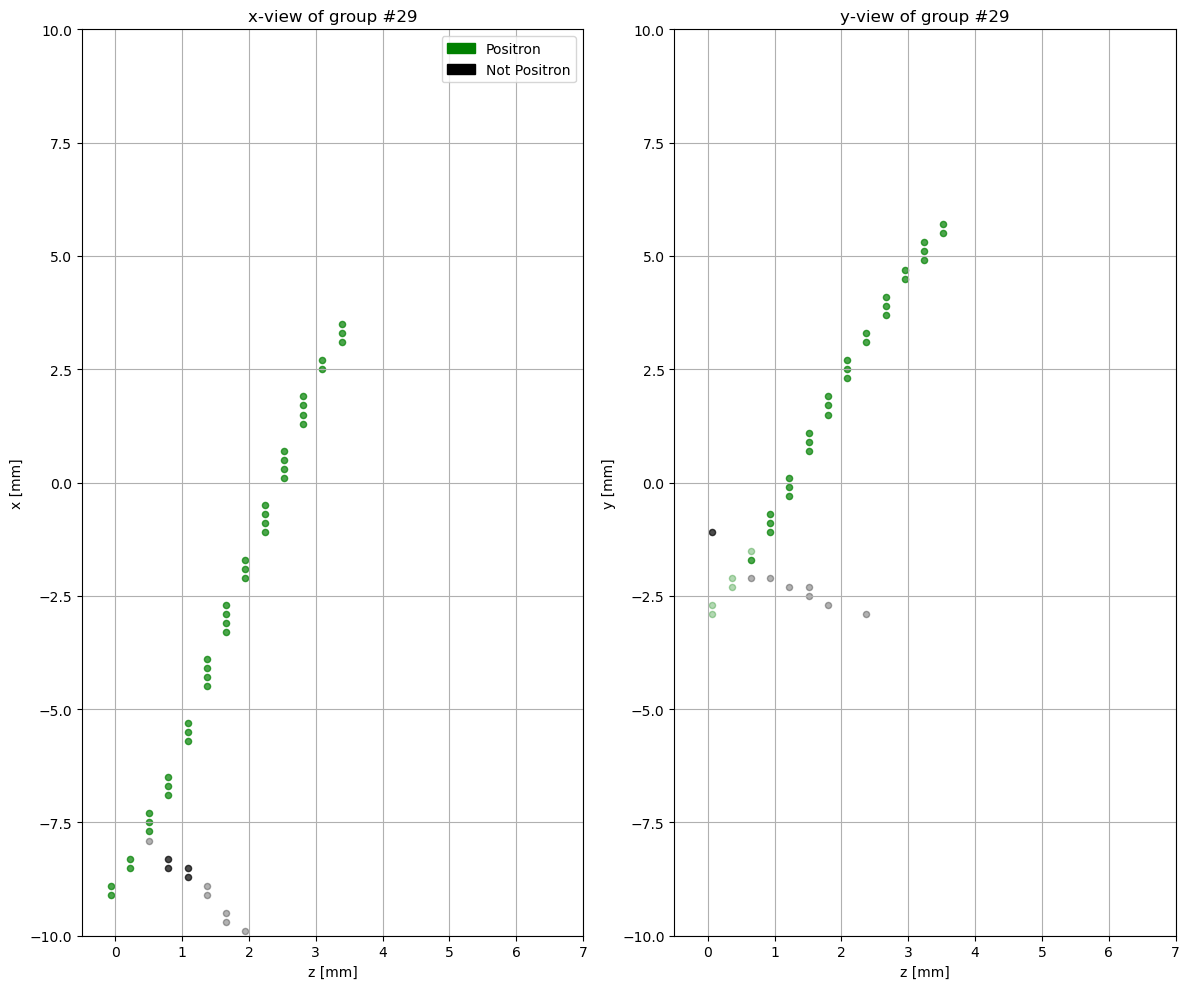

Predictions: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Truth      : [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 1
 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Probabilities (first hit): [0.9974496  0.00255035]


In [201]:
m = 29
visualize_group_n_mc_dropout(
    model=bhabha_model,
    dataset=bhabha_dataset,
    n=m,                # show the 43rd group
    num_samples=10
)